In [1]:
!pip install pytorch-lightning

# Define a Lightning Module

In [2]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import pytorch_lightning as pl

# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

/home/archimickey/mambaforge/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define a dataset

In [6]:
# setup data
dataset = MNIST(root="dataset", download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset)

100%|██████████| 9912422/9912422 [00:00<00:00, 54785764.31it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44683029.81it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20320476.81it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6147314.87it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [7]:
from torchvision.transforms import ToPILImage
img = dataset[0][0].flatten().unsqueeze(-1)
display(ToPILImage()(img))

# Train the model

In [8]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = pl.Trainer(max_epochs=1)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Epoch 0:  73%|███████▎  | 43717/60000 [04:24<01:38, 165.37it/s, loss=0.0379, v_num=13]

# Use the model

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ 
Predictions (4 image embeddings):
 tensor([[-1.6073e+36,  8.1310e+35,  2.3937e+36],
        [-1.7308e+36,  4.6362e+35,  2.0950e+35],
        [ 1.0813e+33,  1.0448e+33,  1.4708e+33],
        [ 5.8182e-02, -2.8380e-02, -4.7841e-02]], grad_fn=<AddmmBackward0>) 
 ⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡


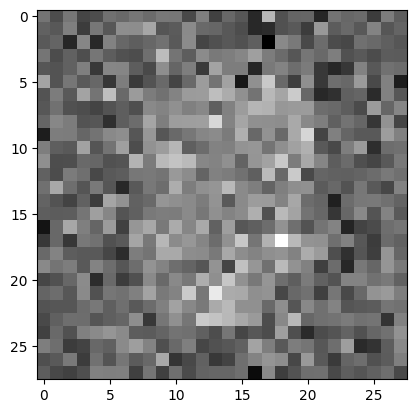

In [ ]:
# load checkpoint
checkpoint = "./lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

# choose your trained nn.Module
encoder = autoencoder.encoder
encoder.eval()

# embed 4 fake images!
fake_image_batch = Tensor(4, 28 * 28)
embeddings = encoder(fake_image_batch)
plt.imshow(embeddings.detach().numpy(), cmap="gray")
print("⚡" * 20, "\nPredictions (4 image embeddings):\n", embeddings, "\n", "⚡" * 20)
decoder = autoencoder.decoder
plt.imshow(decoder(embeddings).view(-1, 28, 28)[0].detach().numpy(), cmap="gray")